In [1]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
from boolrank import *

# dk what this loads
# dataset = load_dataset("data", split="train")
file = "training"
dataset = load_dataset("json", data_files=f"data/{file}.jsonl", split="train")
bool_key = "q"
text_key = "d"

data = dataset.train_test_split(test_size=0.1, seed=42)
print(data)

model = DualSiglip2Model()

c:\Users\Simon\miniconda3\envs\RP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['q', 'd'],
        num_rows: 3782
    })
    test: Dataset({
        features: ['q', 'd'],
        num_rows: 421
    })
})


You are using a model of type siglip_text_model to instantiate a model of type siglip2_text_model. This is not supported for all configurations of models and can yield errors.


In [ ]:
from transformers import Trainer, TrainingArguments
import os

os.environ["WANDB_PROJECT"] = "Boolean-Ranking"
os.environ["WANDB_LOG_MODEL"] = "false"

epochs = 5
batch_size = 2
lr = 1e-5
decay = 0.01
model_path = f"siglip2/b{batch_size}_lr{lr:.0e}_decay{decay:.0e}"

training_args = TrainingArguments(
    output_dir=model_path,
    per_device_train_batch_size=batch_size,
    num_train_epochs=epochs,
    learning_rate=lr,
    weight_decay=decay,
    save_steps=1000,
    save_total_limit=1,
    remove_unused_columns=False,
    bf16=True,
    optim="adamw_bnb_8bit",
    logging_steps=300,
    report_to="wandb",
    # max_steps=1000,
    # torch_compile=True,
    # torch_compile_backend="inductor"
)

def collate_fn(batch):
    d = {
        "in_bool": [ex["q"] for ex in batch],
        "in_text": [ex["d"] for ex in batch],
    }
    return d

trainer = Trainer(
    model,
    training_args,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    data_collator=collate_fn,
)

try: trainer.train(resume_from_checkpoint=True)
except: trainer.train(resume_from_checkpoint=False)

     Top-K | Top-K(perc) |   Recall@K
         1 |       0.00 |       0.12
         2 |       0.00 |       0.20
         4 |       0.01 |       0.31
         8 |       0.02 |       0.45
        16 |       0.04 |       0.63
        32 |       0.08 |       0.76
        64 |       0.15 |       0.88
       128 |       0.30 |       0.95
       256 |       0.61 |       0.98



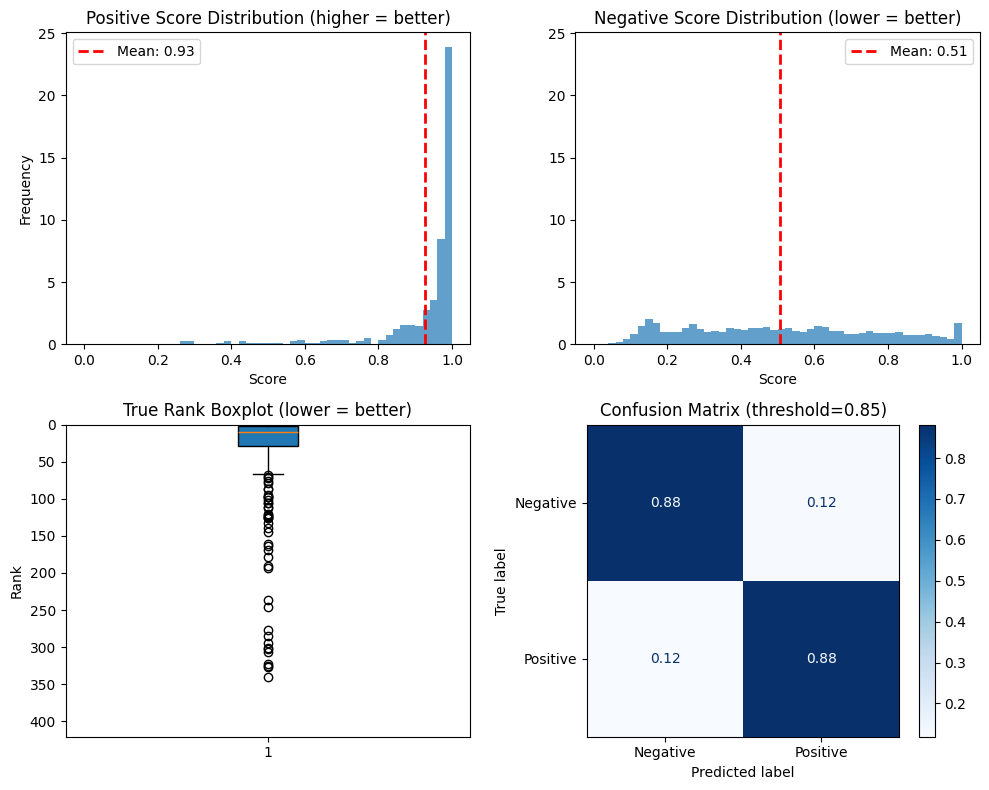

     Top-K | Top-K(perc) |   Recall@K
         1 |       0.02 |       0.16
         2 |       0.04 |       0.26
         4 |       0.08 |       0.38
         8 |       0.16 |       0.44
        16 |       0.32 |       0.60
        32 |       0.64 |       0.84



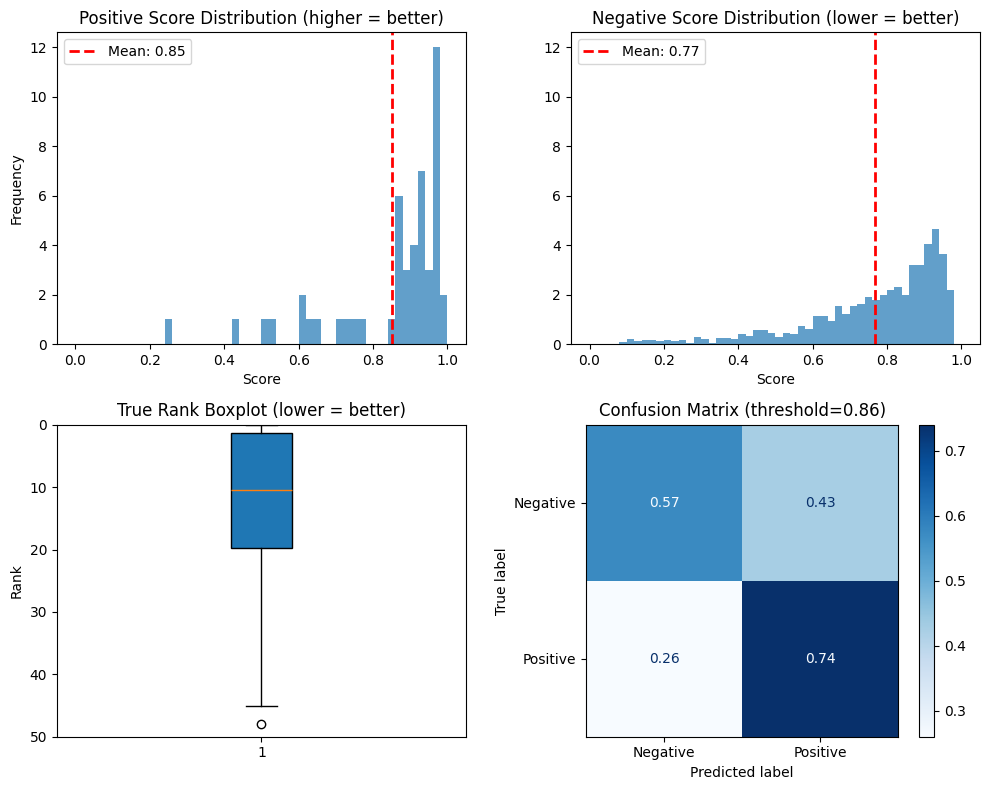

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------




In [3]:
from evaluation import ModelEvaluator
trainer.evaluate()
# paths = [r"./siglip2/old/b2-bf-8b/e4", r"./siglip2/old/b3-bf-8b"]
paths = [None]
amt = 2000
format = "pdf"
bench_data = load_dataset("json", data_files="data/bench_data.jsonl", split="train")
for path in paths:
    if path is not None:
        model.load(path + "/model.safetensors")
        print(path)
    else: path = model_path
    eval = ModelEvaluator(model)
    res = eval.evaluate(data["test"][bool_key][:amt], data["test"][text_key][:amt], plot=True)
    res["plot"].savefig(f"{path}/test_stats.{format}", format=format)
    res = eval.evaluate(bench_data["query"][:amt], bench_data["title"][:amt], plot=True)
    res["plot"].savefig(f"{path}/TAR_stats.{format}", format=format)
    print(("-" * 100 + "\n\n") * 2)

In [ ]:
from process_data import process_searchrefiner_logs

process_searchrefiner_logs()